# Trivia About Trivia


### The Backstory 
Throughout college, every Tuesday night I could, I would go to a bar in downtown Gainesville with a group of friends to play trivia. While at trivia one night we began talking about what makes a good trivia team. We decided that there were certain topics that always popped up in trivia and a good team would have one or two people who knew a lot about those topics. The ones we decided were: 

- sports
- offbeat, esoteric movies and TV
- geography
- history
- current events

### The Setup

As you could imagine, immediately after having this conversation, we began arguing about what player was the most important. So I began thinking....

>#### "What topics come up in trivia the most?"

As a trivia nerd, I've spent more than my fair share of time watching Jeopardy. And when I found a dataset of all the Jeopardy questions and answers used in the shows 15 year history, I knew what I had to do.


- [Exploring the Data](#Exploring-the-Data)
- [Building the Name Entity Recognizer](#Building-the-Name-Entity-Recognizer)
- [Visualizing the Results](#Visualizing-the-Results)
- [Wrap Up](#Wrap-Up)

# Exploring the Data

First things first, we need to bring the csv in and clean it up a bit. First, we can remove all the punctuation and standardize the data a bit. Then there's a few pieces that aren't super relevant to our project, so let's get those out.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [2]:
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value',
       'Question', 'Answer']
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [3]:
import re

def removePunct(word):
    word = re.sub('[^A-Za-z0-9\s]','', word)
    word = word.lower()
    return word

In [4]:
jeopardy['clean_question'] = jeopardy['Question'].apply(removePunct)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(removePunct)

In [5]:
jeopardy.head(10)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$200,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant
6,4680,2004-12-31,Jeopardy!,HISTORY,$400,Built in 312 B.C. to link Rome & the South of ...,the Appian Way,built in 312 bc to link rome the south of ita...,the appian way
7,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$400,"No. 8: 30 steals for the Birmingham Barons; 2,...",Michael Jordan,no 8 30 steals for the birmingham barons 2306 ...,michael jordan
8,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$400,"In the winter of 1971-72, a record 1,122 inche...",Washington,in the winter of 197172 a record 1122 inches o...,washington
9,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$400,This housewares store was named for the packag...,Crate & Barrel,this housewares store was named for the packag...,crate barrel


In [6]:
new = jeopardy[['clean_question', 'clean_answer']]

In [7]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [8]:
new.head()

,clean_question,clean_answer
0,for the last 8 years of his life galileo was u...,copernicus
1,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,the city of yuma in this state has a record av...,arizona
3,in 1963 live on the art linkletter show this c...,mcdonalds
4,signer of the dec of indep framer of the const...,john adams


**Now that everything is a bit cleaner, let's get to some NLP work. First we'll tokenize the strings and remove some stop words to help with efficiency. I played around with stemming or lemmatizing the data but decided that it ended up hurting the end result more than it helped.**

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [10]:
def removeStop(para):
    words = word_tokenize(para)
    useful_words = []
    for i in words:
        if i not in stopwords.words('english'):
            useful_words.append(i)
    return (' ').join(useful_words)
    

In [30]:
new['final_question'] = new['clean_question'].apply(removeStop)
new['final_answer'] = new['clean_answer'].apply(removeStop)

C:\Users\allison.kahn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\allison.kahn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
new.head()

,clean_question,clean_answer,final_question,final_answer
0,for the last 8 years of his life galileo was u...,copernicus,last 8 years life galileo house arrest espousi...,copernicus
1,no 2 1912 olympian football star at carlisle i...,jim thorpe,2 1912 olympian football star carlisle indian ...,jim thorpe
2,the city of yuma in this state has a record av...,arizona,city yuma state record average 4055 hours suns...,arizona
3,in 1963 live on the art linkletter show this c...,mcdonalds,1963 live art linkletter show company served b...,mcdonalds
4,signer of the dec of indep framer of the const...,john adams,signer dec indep framer constitution mass seco...,john adams


# Building the Name Entity Recognizer

In [13]:
import spacy
from spacy import displacy
from collections import Counter

In [15]:
all_ners = []

#nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm')

for ex in new['clean_question']:
    doc = nlp(ex)
    for chunk in doc.noun_chunks:
        all_ners.append(chunk.text)

In [16]:
len(all_ners)

77065

In [24]:
c = Counter(all_ners)
c.most_common(20)

[('he', 1526),
 ('it', 1442),
 ('you', 1323),
 ('i', 734),
 ('who', 725),
 ('she', 472),
 ('the clue crew', 343),
 ('him', 328),
 ('they', 304),
 ('this country', 276),
 ('we', 217),
 ('the name', 207),
 ('us', 198),
 ('this type', 185),
 ('what', 182),
 ('this man', 178),
 ('me', 176),
 ('them', 160),
 ('this city', 152),
 ('the us', 139)]

There's a bunch of clutter in there (looking at you, 'he', all 1526 instances of you). While pronouns aren't traditionally thought of as stopwords, let's see if we get cleaner results if we strip them out.

In [25]:
pronouns = ['i', 'me', 'we', 'us', 'you', 'he','she', 'her', 'him', 'it', 'they', 'them']
cleaned_c = c

for i in list(cleaned_c):
    if i in pronouns:
        del cleaned_c[i]

In [26]:
len(cleaned_c)

46482

In [28]:
cleaned_c.most_common(20)

[('who', 725),
 ('the clue crew', 343),
 ('this country', 276),
 ('the name', 207),
 ('this type', 185),
 ('what', 182),
 ('this man', 178),
 ('this city', 152),
 ('the us', 139),
 ('this state', 128),
 ('its name', 124),
 ('part', 111),
 ('the world', 105),
 ('this word', 91),
 ('the latin', 78),
 ('the title', 76),
 ('this author', 70),
 ('president', 69),
 ('something', 68),
 ('this name', 64)]

# Visualizing the Results

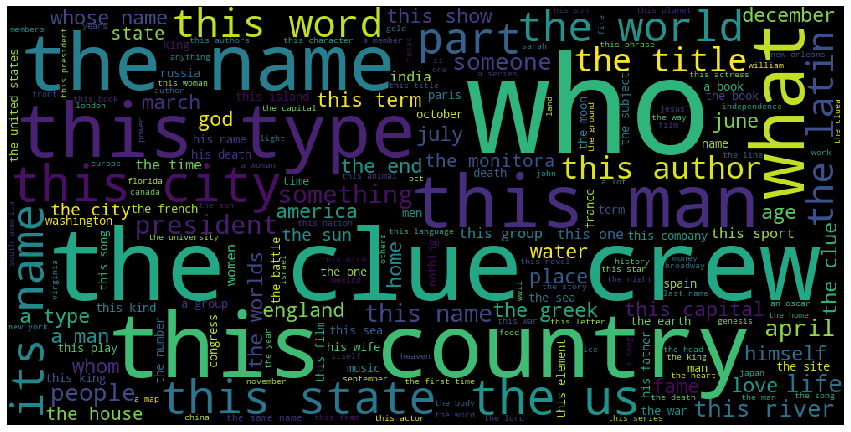

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(cleaned_c)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

So there's 46,482 entities found across the data. I wonder how many of these entities only occur once or twice?

In [67]:
freq_of_freq = list(cleaned_c.values())
count_of_freq = Counter(freq_of_freq)
count_of_freq.most_common(20)

[(1, 40144),
 (2, 3278),
 (3, 1116),
 (4, 543),
 (5, 335),
 (6, 233),
 (7, 151),
 (8, 112),
 (9, 83),
 (10, 62),
 (11, 53),
 (12, 44),
 (13, 38),
 (16, 25),
 (14, 24),
 (18, 24),
 (15, 20),
 (19, 18),
 (22, 16),
 (20, 15)]

That's definitive. Over 40,000 (86%) of our entities only occur one time and another 7% occur twice. I wonder what the least common entities look like:

In [103]:
cleaned_c.most_common()[-20:-1]

[('a hrefhttpwwwjarchivecommedia20090514dj25wmvcluesa', 1),
 ('medieval england', 1),
 ('the smallest unit', 1),
 ('a minute', 1),
 ('an africanamerican mayor', 1),
 (' the crickets', 1),
 ('the 990s', 1),
 ('erik', 1),
 ('a failed windows', 1),
 ('98 demonstration', 1),
 ('some bugs', 1),
 ('this llama product', 1),
 ('hats blankets', 1),
 ('its chocolatecovered ding dong snack cakes', 1),
 (' the new power generation', 1),
 ('the grand jury', 1),
 ('linda tripp', 1),
 ('llamas', 1),
 ('the heftiest south american members', 1)]

Seems to me that the group that stands out the most to me is geography based (this country, this capital, this river, this city, etc). It also seems that knowing root languages would also be helpful, given how common 'the greek' and 'the latin' are.

Interestingly enough, it seems that December and April have the most clues written about them. There's also a god number of literary references, a position that we hadn't originally included in our argument.

All in all, it seems that the best way to study for jeopardy is to study geography and to stay away from llamas. Which leaves the final question...

## What is the most common answer in Jeopardy? _(Or question I guess?)_

In [105]:
count_answers = Counter(new['final_answer'])
count_answers.most_common(20)

[('', 42),
 ('japan', 22),
 ('texas', 20),
 ('india', 19),
 ('australia', 19),
 ('china', 19),
 ('canada', 19),
 ('italy', 18),
 ('chicago', 17),
 ('california', 16),
 ('hawaii', 16),
 ('paris', 16),
 ('france', 15),
 ('germany', 15),
 ('alaska', 15),
 ('woodrow wilson', 15),
 ('washington', 14),
 ('spain', 14),
 ('greece', 13),
 ('london', 13)]

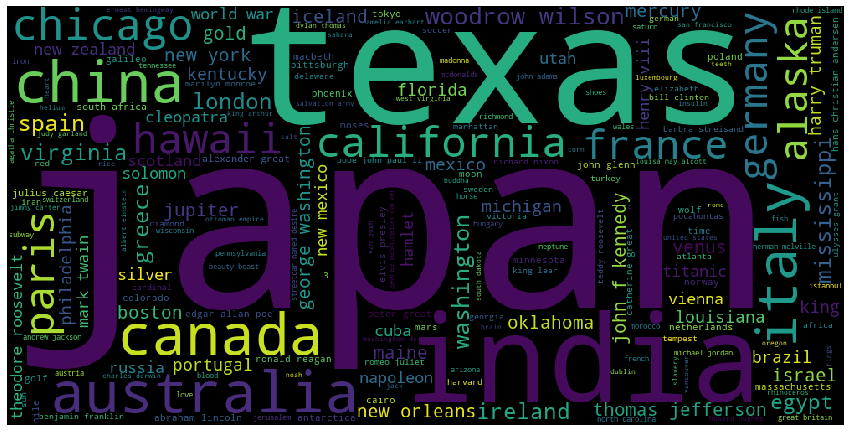

In [106]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(count_answers)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [107]:
categories = []
nlp = spacy.load('en')
for i in new['final_answer']:
    doc = nlp(i)
    for x in doc.ents:
        categories.append((X.text, X.label_))

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

# Wrap Up

Looks like a bunch of countries, which could come from any of a variety of question types, and presidents (George Washington: understandable; Harry Truman: a mystery). 